# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier



## Step 0: Load The Data
First, we load the train and test data from pickle files.

In [1]:
# 1st code cell
# Load pickled data
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_raw, y_train_raw = train['features'], train['labels']
X_test_raw, y_test_raw = test['features'], test['labels']



## Step 1: Dataset Summary & Exploration

Let's take a look at the data. The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image

### Data Set Summary

In [2]:
# 2nd code cell
### Data Summary

# Number of training examples
n_train = X_train_raw.shape[0]

# Number of testing examples.
n_test = X_test_raw.shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_train_raw.shape[1], X_train_raw.shape[2])

# How many unique classes/labels there are in the dataset.
n_classes = len( set( y_train_raw ) )

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Data Set Visualization

Let's start with picking some signs out at random and displaying them along with their text labels. And let's see how evenly distributed the labels are.


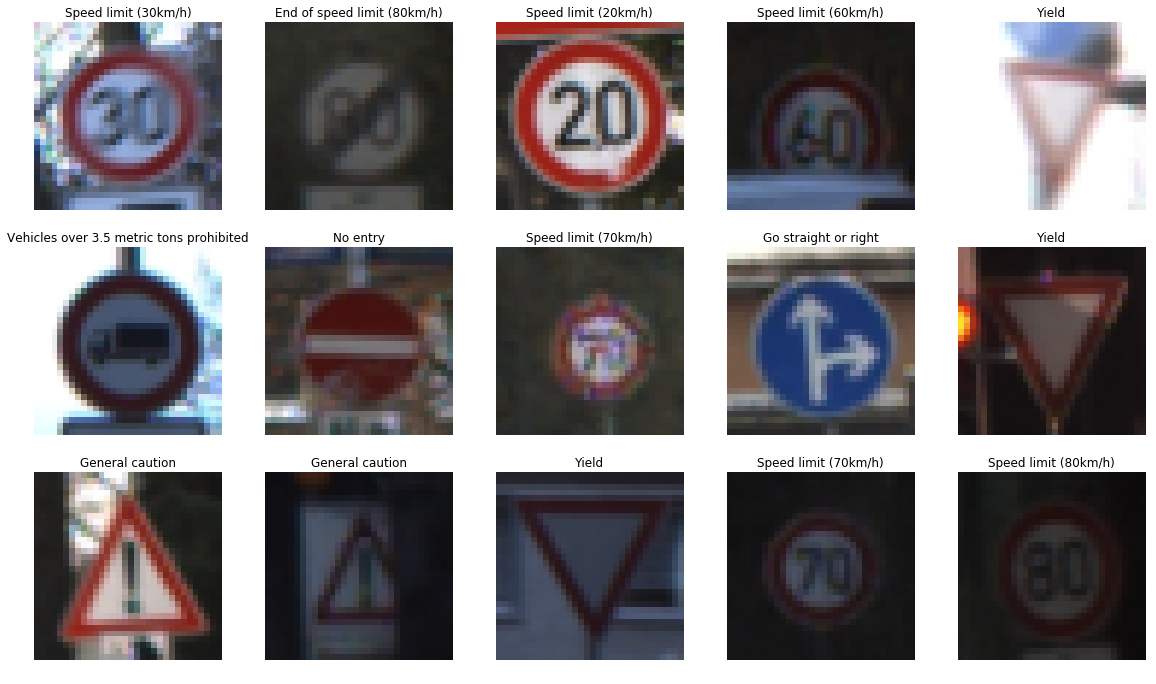

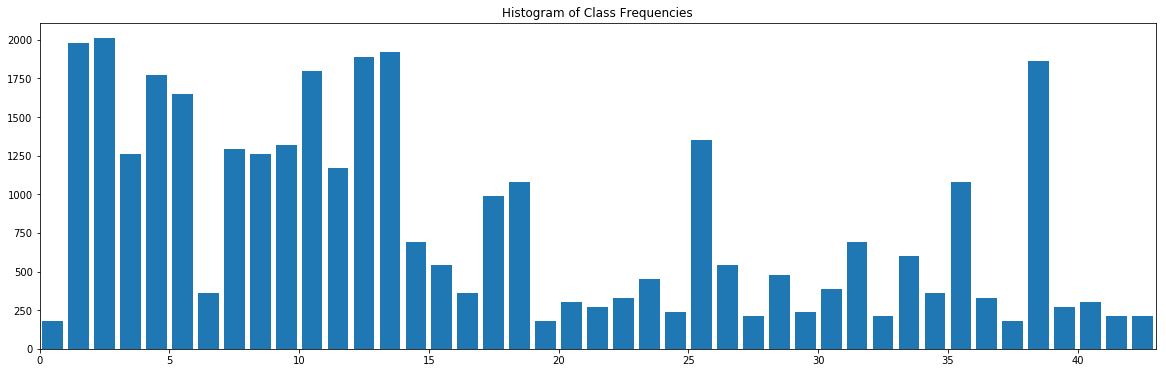

In [3]:
# 3rd code cell
### Data exploration visualization
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
import pandas as pd
import numpy as np

# Read sign names
sn = pd.read_csv('./signnames.csv')

# Plot 15 signs at random
fig = plt.figure(figsize=(20,20))
for i in range(1,16):
    a = fig.add_subplot(5,5,i)
    signidx = randint(0, n_train)
    plt.imshow(X_train_raw[signidx])
    code = int(y_train_raw[signidx])
    plt.title( sn.iloc[code, 1] )
    plt.axis('off')
    
# Plot histogram of class frequency
histogram = np.histogram(y_train_raw, bins=n_classes, range=(0, n_classes))
fig = plt.figure(figsize=(20,6))
bin_edges = histogram[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
plt.bar(bin_centers, histogram[0])
plt.xlim(0, n_classes)
plt.title('Histogram of Class Frequencies')



Not very even, but this might reflect actual world occuring frequencies.


## Step 2: Design and Test a Model Architecture

Let's learn from this data set.


### Preprocess the Data Set (normalization, grayscale, etc.)

First, we shuffle the training data. Then we normalize the brightness.


 Before and after normalisation: 


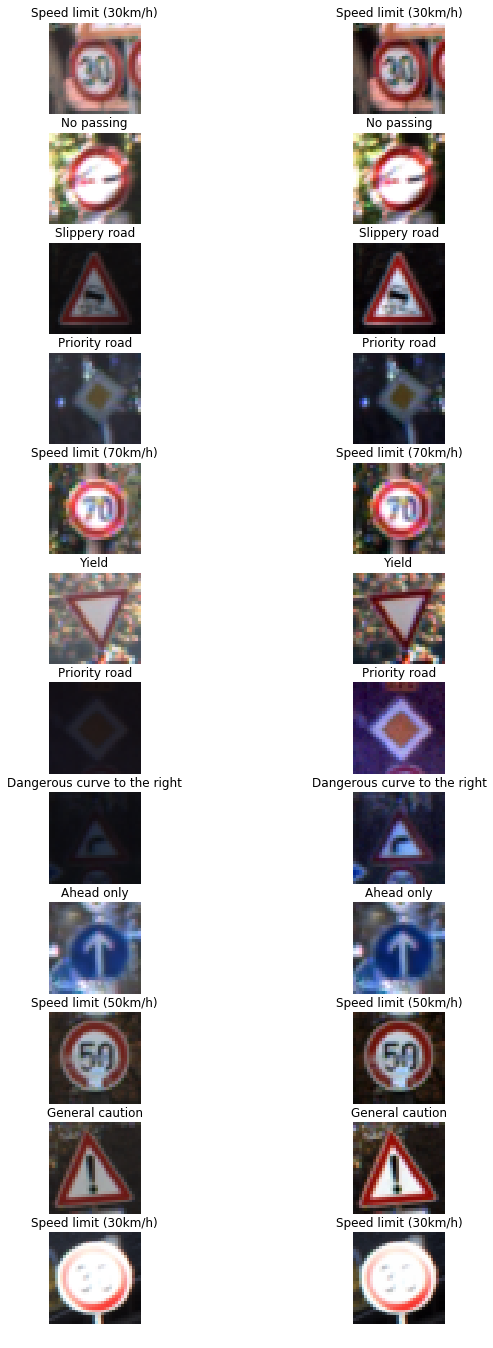

In [4]:
# 4th code cell
### Preprocess the data.
from sklearn.utils import shuffle
from skimage.exposure import rescale_intensity
import cv2 

# Shuffle
X_train_shuffled, y_train_shuffled = shuffle( X_train_raw, y_train_raw )

# Define preprocessing
def preprocess_images( X_train_in, y_train_in ):
    # Normalise
    X_train = []
    y_train = []
    for i, (image, label) in enumerate( zip( X_train_in, y_train_in ) ):
        zeros = np.zeros((32,32,3))
        normalised_image = cv2.normalize(image, zeros, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        X_train.append( normalised_image )
        y_train.append( label )
    return np.array( X_train ), y_train

# Preprocess
X_train, y_train = preprocess_images( X_train_shuffled, y_train_shuffled )

# Plot 25 signs at random, before and after
print( " Before and after normalisation: " )
fig = plt.figure(figsize=(10,30))
for i in range(1,25, 2):
    signidx = randint(0, n_train)

    a = fig.add_subplot(15,2,i)
    plt.imshow(X_train_shuffled[signidx])
    code = int(y_train_shuffled[signidx])
    plt.title( sn.iloc[code, 1] )
    plt.axis('off')

    a = fig.add_subplot(15,2,i+1)
    plt.imshow(X_train[signidx])
    code = int(y_train[signidx])
    plt.title( sn.iloc[code, 1] )
    plt.axis('off')




### Split Data into Training, Validation and Testing Sets

In [5]:
# 5th code cell
### Split the data into training/validation sets.
from sklearn.model_selection import train_test_split

# Split. Let's say 20% of the data goes to validation.
X_train, X_validation, y_train, y_validation = train_test_split( X_train, y_train, test_size=0.2, random_state=0)

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples.
n_validation = X_validation.shape[0]




In [6]:
# 6th code cell

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of test examples =", n_test)



Number of training examples = 27839
Number of validation examples = 6960
Number of test examples = 12630


### Model Architecture
And now, we define the model architecture. Let's use an adapted LeNet model.

In [7]:
# 7th code cell
from tensorflow.contrib.layers import flatten

# Define the model
def LeNet(x):
    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # ReLU Activation
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # ReLU Activation
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # ReLU Activation
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # ReLU Activation
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    # That's it
    return logits


### Train, Validate and Test the Model

Let's train. Let's try 128 batch size. We hope for accuracy > 95%.


In [8]:
#8th code cell
### Train
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 128
rate = 0.001

# Inputs
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# TF Operations
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Let's save when done
saver = tf.train.Saver()

# Evaluate the model on a data set
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Train
def train(X_train, y_train):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

            # Evaluate
            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, './lenet')
        print("Model saved")

train(X_train, y_train)


Training...

EPOCH 1 ...
Validation Accuracy = 0.815

EPOCH 2 ...
Validation Accuracy = 0.895

EPOCH 3 ...
Validation Accuracy = 0.940

EPOCH 4 ...
Validation Accuracy = 0.952

EPOCH 5 ...
Validation Accuracy = 0.957

EPOCH 6 ...
Validation Accuracy = 0.968

EPOCH 7 ...
Validation Accuracy = 0.971

EPOCH 8 ...
Validation Accuracy = 0.972

EPOCH 9 ...
Validation Accuracy = 0.975

EPOCH 10 ...
Validation Accuracy = 0.969

EPOCH 11 ...
Validation Accuracy = 0.968

EPOCH 12 ...
Validation Accuracy = 0.976

EPOCH 13 ...
Validation Accuracy = 0.974

EPOCH 14 ...
Validation Accuracy = 0.980

EPOCH 15 ...
Validation Accuracy = 0.982

EPOCH 16 ...
Validation Accuracy = 0.976

EPOCH 17 ...
Validation Accuracy = 0.983

EPOCH 18 ...
Validation Accuracy = 0.983

EPOCH 19 ...
Validation Accuracy = 0.982

EPOCH 20 ...
Validation Accuracy = 0.985

EPOCH 21 ...
Validation Accuracy = 0.982

EPOCH 22 ...
Validation Accuracy = 0.978

EPOCH 23 ...
Validation Accuracy = 0.984

EPOCH 24 ...
Validation Accura


Nice.



## Test
Now that we've finished tweaking our model, let's finally run it on the test set to see how well it does.

In [10]:
# 9th code cell
# Test. Run when done.
with tf.Session() as sess:
    # Load model
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Evaluate test data
    X_test, y_test = preprocess_images( X_test_raw, y_test_raw )
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

Test Accuracy = 0.924


---

## Step 3: Test a Model on New Images

To get more insight into how the model is working, I've downloaded new images by screenshotting images of German traffic signs from Google Street View in Berlin and downloading from Google Image Search.

### Load and Output the Images

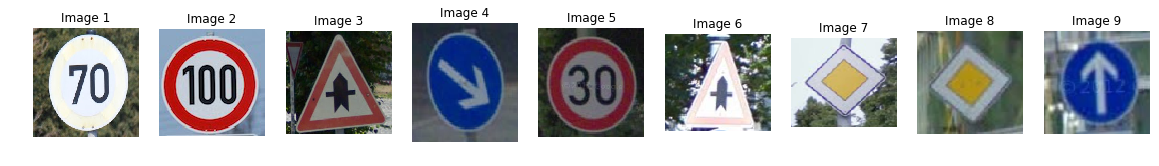

In [11]:
# 10th code cell
# New Images
import glob

# Find and read images in test directory
filelist = sorted(glob.glob( './test/*.*' ))
images = np.array([np.array(plt.imread(fname)) for fname in filelist])

# Plot in a row
fig = plt.figure(figsize=(20,20))
for i in range(0,len(images)):
    a = fig.add_subplot(1,len(images),i+1)
    plt.imshow(images[i])
    code = int(y_train[1])
    plt.title( "Image " + str(i+1) )
    plt.axis( "off" )

### Predict the Sign Type for Each Image

Predicted classes: [ 4  1 11 38  1 26 12 12 35]


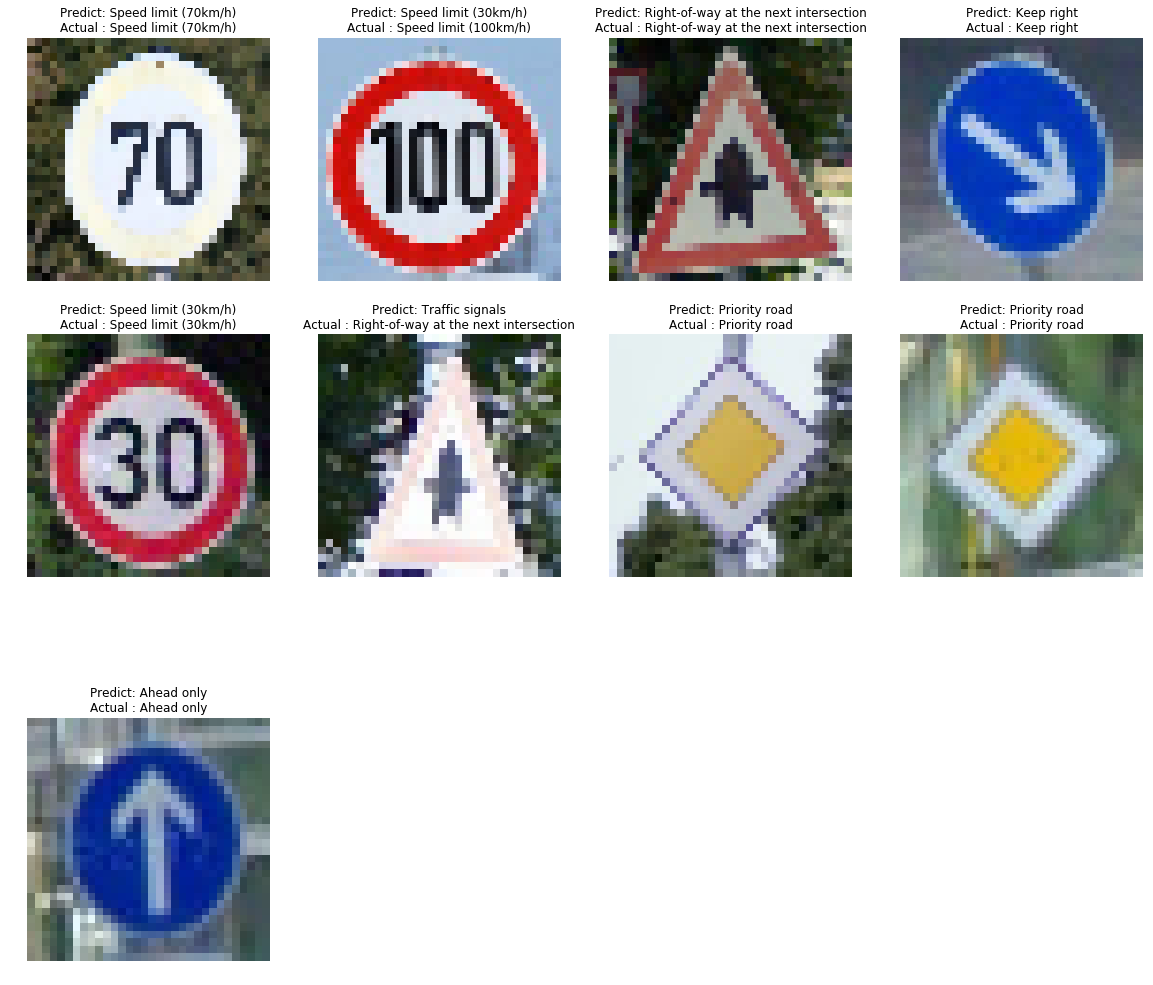

In [12]:
# 11th code cell
### Run the predictions and use the model to output the prediction for each image.

# What are the actual sign labels?
y_correct_in = [ 4, 7, 11, 38, 1, 11, 12, 12, 35 ]

# Find and read images in test directory
filelist = sorted( glob.glob( './test/*.*' ) )
images_in = [ cv2.imread(filename) for filename in filelist ]
images_in = [ cv2.cvtColor( image, cv2.COLOR_BGR2RGB ) for image in images_in ]

# Resize to 32x32 for model
images_in = np.array( [ cv2.resize( image, (32, 32) ) for image in images_in ] )

# Preprocess
images, y_correct = preprocess_images( images_in, y_correct_in )

# Predict with model
with tf.Session() as sess:
    # Load model
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Predict
    preds = sess.run(tf.argmax(logits, 1), feed_dict={x:images})
    print( "Predicted classes: " + str( preds ) )

# Read sign names
sn = pd.read_csv('./signnames.csv')

# Plot
fig = plt.figure(figsize=(20, 20))
for i in range(0,len(images)):
    a = fig.add_subplot(2 + ((i+1) / 5), len(images)/2, i + 1 )
    plt.imshow(images[i])
    code = preds[i]
    plt.title( "Predict: " + str( sn.iloc[code, 1] ) + "\nActual : " + str( sn.iloc[y_correct[i], 1] ) )
    plt.axis("off")


### Analyze Performance

In [13]:
# 12th code cell
### Calculate the accuracy for the new images. 

correct = 0
for i in range(0, len(images)):
    print( "Image " + str( i +1 ) + ": ", preds[i], y_correct[i])
    if preds[i] == y_correct[i]:
        correct += 1

print( "" )
print( "Correct predictions: " + str( correct ) + " / " + str( len(preds) ) + " = " + str( round( 100.0 * correct / len(preds), 2) ) + "%" )    
print( "" )
    

Image 1:  4 4
Image 2:  1 7
Image 3:  11 11
Image 4:  38 38
Image 5:  1 1
Image 6:  26 11
Image 7:  12 12
Image 8:  12 12
Image 9:  35 35

Correct predictions: 7 / 9 = 77.78%




How sure was the model that it predicted correctly?


### Model Confidence: Top 5 Softmax Probabilities

Let's see how *confident* the model is on these new images.

In [14]:
# 13th code cell
### Print out the top five softmax probabilities

# Predict with model
with tf.Session() as sess:
    # Load model
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    top_5 = tf.nn.top_k( tf.nn.softmax(logits), 5 )
    softmax = tf.nn.softmax(logits)
    argmax = tf.argmax(logits, 1)

    # Predict
    top, sm, preds = sess.run([top_5, softmax, argmax], feed_dict={x:images})
    for i, pred in enumerate( preds ):
        print( "Percentage predicted confidence of image " + str( i + 1 ) + ": " + str( round( 100.0 * sm[i][pred], 2 ) ) + \
              "%. Top 5 predictions: " + str( top[1][i] ) + " (Actual: " + str(y_correct[i]) + "),\nPrediction confidences: " + \
              str( np.round( top[0][i], 3 ) ) + " \n" )

    

Percentage predicted confidence of image 1: 76.63%. Top 5 predictions: [ 4 12  1  0 40] (Actual: 4),
Prediction confidences: [ 0.76599997  0.228       0.006       0.          0.        ] 

Percentage predicted confidence of image 2: 100.0%. Top 5 predictions: [1 8 0 5 4] (Actual: 7),
Prediction confidences: [ 1.  0.  0.  0.  0.] 

Percentage predicted confidence of image 3: 100.0%. Top 5 predictions: [11 30 12 27 26] (Actual: 11),
Prediction confidences: [ 1.  0.  0.  0.  0.] 

Percentage predicted confidence of image 4: 100.0%. Top 5 predictions: [38 18 34 36 25] (Actual: 38),
Prediction confidences: [ 1.  0.  0.  0.  0.] 

Percentage predicted confidence of image 5: 100.0%. Top 5 predictions: [ 1  0  4  2 18] (Actual: 1),
Prediction confidences: [ 1.  0.  0.  0.  0.] 

Percentage predicted confidence of image 6: 52.86%. Top 5 predictions: [26 12 11 33 30] (Actual: 11),
Prediction confidences: [ 0.52899998  0.322       0.149       0.          0.        ] 

Percentage predicted confide